In [2]:
# Imports
import pandas as pd
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import numpy as np


In [3]:
blinds1 = pd.read_csv("../../data3/blinds_data/blinds_meetingroom_1.csv")
blinds2 = pd.read_csv("../../data3/blinds_data/blinds_meetingroom_2.csv")
blinds3 = pd.read_csv("../../data3/blinds_data/blinds_meetingroom_3_offset2seconds.csv")
blinds4 = pd.read_csv("../../data3/blinds_data/blinds_meetingroom_4.csv")

hallway1 = pd.read_csv("../../data3/hallway_data/hallway_1.csv")
hallway2 = pd.read_csv("../../data3/hallway_data/hallway_2.csv")
hallway3 = pd.read_csv("../../data3/hallway_data/hallway_3.csv")
hallway4 = pd.read_csv("../../data3/hallway_data/hallway_4.csv")

windows1 = pd.read_csv("../../data3/windows_data/windows_meetingroom_1.csv")
windows2 = pd.read_csv("../../data3/windows_data/windows_meetingroom_2.csv")
windows3 = pd.read_csv("../../data3/windows_data/windows_meetingroom_3.csv")
windows4 = pd.read_csv("../../data3/windows_data/windows_meetingroom_4.csv")


In [4]:
# 2. Concatenate and assign labels + group IDs
dfs   = [blinds1, blinds2, blinds3,
         hallway1, hallway2, hallway3,
         windows1, windows2, windows3]

labels   = []
groups   = []
group_id = 0

for df in dfs:
    # determine room type from filename in practice; here we infer by position
    if group_id < 3:
        room = "BLINDS"
    elif group_id < 6:
        room = "HALLWAYS"
    else:
        room = "WINDOWS"
    labels += [room] * len(df)
    groups += [group_id] * len(df)
    group_id += 1

X_train = pd.concat(dfs, axis=0, ignore_index=True)
y_train = np.array(labels)
groups  = np.array(groups)

# 3. Feature selection & label encoding
#   keep only numeric columns (drop time or other metadata if present)
numeric_cols = X_train.select_dtypes(include="number").columns
X_train = X_train[numeric_cols].astype(float)

le = LabelEncoder()
y_train = le.fit_transform(y_train)   # 0=BLINDS,1=HALLWAYS,2=WINDOWS

# 4. Build pipeline and parameter grid
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm",    SVC(decision_function_shape="ovo", probability=True))
])

param_grid = {
    "svm__C":     [0.1, 1, 10],
    "svm__gamma": ["scale", 0.01, 0.001],
   
}

# 5. 3‑fold GroupKFold CV (each fold holds out one trial)
gkf = GroupKFold(n_splits=3)

search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=gkf.split(X_train, y_train, groups),
    scoring="accuracy",
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# 6. Run the grid search
search.fit(X_train, y_train)

# 7. Report results
print("Best parameters:", search.best_params_)
print(f"Best CV accuracy: {search.best_score_:.4f}\n")

# If you want the full CV table:
cv_results = pd.DataFrame(search.cv_results_)
print(cv_results[[
    "param_svm__C", "param_svm__gamma",
    "mean_test_score", "std_test_score"
]])

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters: {'svm__C': 10, 'svm__gamma': 0.001}
Best CV accuracy: 0.9073

   param_svm__C param_svm__gamma  mean_test_score  std_test_score
0           0.1            scale         0.847245        0.083087
1           0.1             0.01         0.890673        0.101203
2           0.1            0.001         0.704941        0.112776
3           1.0            scale         0.893550        0.121648
4           1.0             0.01         0.906977        0.109206
5           1.0            0.001         0.904390        0.094613
6          10.0            scale         0.895320        0.126466
7          10.0             0.01         0.899577        0.135348
8          10.0            0.001         0.907329        0.117858


Test   accuracy on trial 4:  0.9350253807106599

Classification report:
              precision    recall  f1-score   support

      BLINDS       0.87      0.97      0.92       360
    HALLWAYS       1.00      1.00      1.00       302
     WINDOWS       0.96      0.84      0.89       323

    accuracy                           0.94       985
   macro avg       0.94      0.94      0.94       985
weighted avg       0.94      0.94      0.93       985



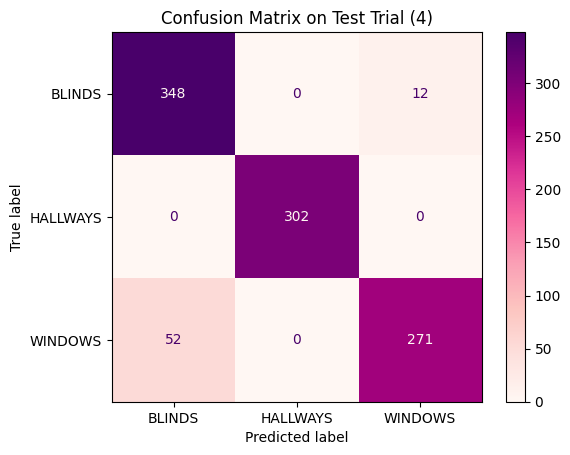

In [ ]:
dfs_test = [blinds4, hallway4, windows4]
labels_test = (["BLINDS"]  * len(blinds4)
             + ["HALLWAYS"] * len(hallway4)
             + ["WINDOWS"] * len(windows4))

X_test = pd.concat(dfs_test, axis=0, ignore_index=True)
y_test = np.array(labels_test)

# --- 3. Select the same numeric features you used in training ---
# (Assuming you stored numeric_cols previously)
# e.g. numeric_cols = X_train.select_dtypes(include="number").columns.tolist()
X_test = X_test[numeric_cols].astype(float)

# --- 4. Encode y_test with the same LabelEncoder ---
y_test_enc = le.transform(y_test)    # BLINDS→0, HALLWAYS→1, WINDOWS→2

# --- 5. Get the best pipeline from your grid search ---
best_model = search.best_estimator_

# --- 6. Predict on trial 4 and compute metrics ---
y_pred = best_model.predict(X_test)

print("Test   accuracy on trial 4: ", accuracy_score(y_test_enc, y_pred))
print("\nClassification report:")
print(classification_report(y_test_enc, y_pred, target_names=le.classes_))

# Optional: plot confusion matrix
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay.from_predictions(
    y_test_enc, y_pred, display_labels=le.classes_,
    cmap=plt.cm.RdPu, normalize=None
)
plt.title("Confusion Matrix on Test Trial (4)")
plt.show()